# Machine Learning

In this step we used the data from the multiclass classification dataframe to develop multiple models of machine learning (ML). The main goal of the criation of these models is to select the most adequate one for the prediction of the data we are studying.

We resorted to the linear_model class from the python package sklearn. This class will build prediction models for Random Forest, Support Vecto Machine (SVM), and k-nearest neighbors (KNN) for the data present in the different dataframes. The class init first needs to receive the data that will be used for the training step and the data that will be used for the model test. This division was performed using the sklearn **train_test_split** function. 

Given that the main objective throughout this step will be the prediction of multiclass classification, the machine learning models chosen for each classification were:

• **LogisticRegression** - "Logistic regression" is a Machine Learning classification algorithm that is used to predict the probability of certain classes based on some dependent variables. In short, the logistic regression model computes a sum of the input features (in most cases, there is a bias term), and calculates the logistic of the result. 

• **Random Forest** – Supervised Machine Learning model consisting of the construction of multiple decision trees, merging them in order to obtain a better and more stable forecast. This model is typically used for regression or classification problems.

• **SVM** - "Support Vector Machine" is a supervised machine learning model for regression and classification problems, and it is more usual to use this for classification problems, which consists of representing the data in an n-dimensional space where each value corresponds to a specific coordinate. The prediction is obtained from the best hyperplane found for significant differentiation of the different classes.

• **KNN** - "K-nearest neighbors" is a supervised machine learning model used for classification and regression problems, this model groups the data into the different K classifications depending on their proximity distance. This model is considered a "lazy learner algorithm" since the training set will not be immediately used, but stored, being only used when a new classification arises.

### Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Dataset upload

**data_feature_x_new** - dataset we obtained after doing the feature selection in the preprocessing 

**data_feature_y** - dataset containing the class 'ec_lev'

In [2]:
data_feature_x_new = pd.read_csv('/content/drive/MyDrive/sistemas/data_feature_x_new.csv')
data_feature_y = pd.read_csv('/content/drive/MyDrive/sistemas/data_feature_y.csv')

Transformimg the dataset into an array.

In [3]:
data_feature_y = data_feature_y.to_numpy().flatten()

Spliting the dataset in train and test using the **train_test_split** function of the sklearn package. The division of the dataset was made using 70% for the training phase and 30% for the test phase, with a random_state of 32.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_feature_x_new, data_feature_y, test_size = 0.3, random_state = 32)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382, 253) (9382,)
Test:  (4022, 253) (4022,)


For these models we used 9382 inputs for training and 4022 inputs for the testing. 

## Test one simple model - Logistic Regression

The first model trained was the Logistic Regression model from the sklearn package.

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

The following **score_test_set** function evaluates the model comparing the predicted values with the real values. The following metrics were used in this function:

• **accuracy** - evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made

• **MCC** -  measure of the quality of multiclass classification. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes

• **f1 score** - harmonic mean between precision and recall. It is used as a statistical measure to rate performance based on two factors (precision and recall for example)

• **confusion matrix** - matrix used to determine the performance of the classification models for a given set of test data 

• **false discovery rate** - controls the number of tests falsely declared significant as a proportion of the number of all tests declared significant

• **Sensitivity, hit rate, recall, or true positive rate** - ability of a classifier to find all positive instances. Explors the impact of feature changes on the model

• **Specificity or true negative rate** - recall of the negative instances. It is inversely proportional to the sensitivity

• **Classification Report** - summary of precision, recall, f1 score for all the seven classes

Accuracy: 0.5927

MCC: 0.5245

f1 score: [0.57305195 0.49183147 0.55154639 0.55840928 0.77383592 0.48639157
 0.74535166]

Confusion Matrix:



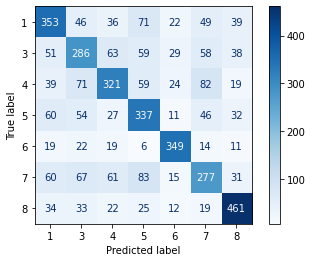


False discovery rate:
 [0.42694805 0.50604491 0.41530055 0.4734375  0.24458874 0.49174312
 0.26941363]

Sensitivity, hit rate, recall, or true positive rate:
 [0.57305195 0.48972603 0.52195122 0.59435626 0.79318182 0.46632997
 0.76072607]

Specificity or true negative rate:
 [0.92278332 0.91477603 0.93307896 0.91230101 0.96845338 0.9218203
 0.95023419]

Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.57      0.57       616
           3       0.49      0.49      0.49       584
           4       0.58      0.52      0.55       615
           5       0.53      0.59      0.56       567
           6       0.76      0.79      0.77       440
           7       0.51      0.47      0.49       594
           8       0.73      0.76      0.75       606

    accuracy                           0.59      4022
   macro avg       0.60      0.60      0.60      4022
weighted avg       0.59      0.59      0.59      4022



In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, precision_recall_curve

def score_test_set(model, X_test, y_test):
    # score test set
    y_pred = model.predict(X_test)
    
    try:
        y_prob = model.predict_proba(X_test)
        
    except:
        y_prob = None
        
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('\nMCC:', round(matthews_corrcoef(y_test, y_pred), 4))
    print('\nf1 score:', f1_score(y_test, y_pred, average = None)) 
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n')

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    
    FP = (cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)).astype(float) # false positive
    FN = (cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)).astype(float) # false negative
    TP = (np.diag(cnf_matrix)).astype(float)                          # true positive
    TN = (cnf_matrix.sum() - (FP + FN + TP)).astype(float)            # true negative
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    
    # False discovery rate
    FDR = FP/(TP+FP)
    
    print('\nFalse discovery rate:\n', FDR)
    print('\nSensitivity, hit rate, recall, or true positive rate:\n', TPR)
    print('\nSpecificity or true negative rate:\n', TNR)
    
    y_pred = model.predict(X_test)
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

score_test_set(model, X_test, y_test)

The model obtained an accuracy of 59,27% and a MCC of 0.5245.

#### ROC curve

**ROCAUC** (Receiver Operating Characteristic/Area Under the Curve) plot allows the user to visualize the tradeoff between the classifier’s sensitivity and specificity.

When plotted, the Receiver Operating Characteristic ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

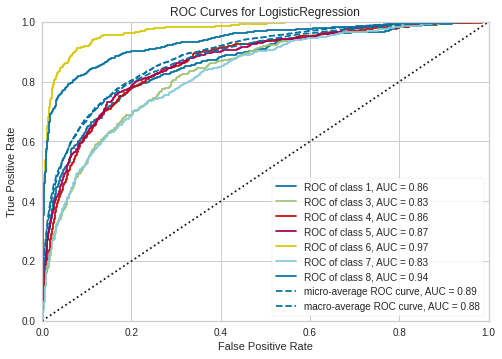

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f342077dfd0>,
       encoder={1: '1', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'},
       estimator=LogisticRegression())

In [7]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model,X_train, X_test, y_train, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder= {1:"1",
                                         3:"3",
                                         4:"4",
                                         5:"5",
                                         6:"6",
                                         7:"7",
                                         8:"8"})                  
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

plot_ROC_curve(model,X_train, X_test, y_train, y_test)

The class with the most true positive values is the class 6 because it has the higher value of the y axis compared with the others. It has an AUC of 0.97, meaning that there is a 97% change that the model will be able to distinguish the positive class from the negative class. 

## Compare multiple models by cross-validation score

**CV score** -  The training set is split into k smaller sets. 
    For each of the k “folds”:
        A model is trained using  of the folds as training data;
        The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive.

We utilized a **kfold** of 10 and used the **accuracy** function to compare the models.

In [8]:
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#Test and compare multiple models

models = [('LR', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),  
          ('SVM', SVC())]


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)

    cross_val = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)

LR: 0.595293 SD:0.017373
RF: 0.758368 SD:0.009499
KNN: 0.670964 SD:0.015700
SVM: 0.718291 SD:0.016126


By observing the results, we can see that the RF and the SVM models obtained the best score among all the models tested.

#### Ploting of the cross-validation results

With the results obtained previously we made boxplots for each model to visualy compare the results and check any existent outliers.

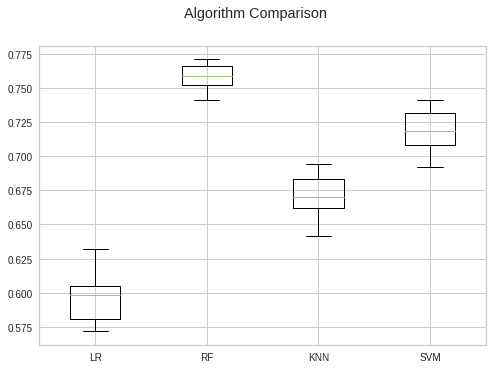

In [9]:
# Plot the results
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Optimize best models - RF and SVM with Grid-Search hyperparameter optimization 

In order to optimize the two best models obtained in cross-validation (**Random Forest** and **SVM**), we resorted to make a hyperparameter optimization using a method called **Grid-Search** implemented in sklearn. Grid-Searching consists of analyzing data to optimize the hyperparameters used in the development of machine learning models. This process can be computationally costly.

Since the **Grid-Search** process will build different models through cross-validation using only training data, for each possible combination of hyperparameters.

This model will eventually be evaluated by the test dataset, dataset with an input dataset never used in the GridSearch training process. The **GridSearchCV** function takes the following parameters:

• **SVC** - used machine learning model (SVM)

• **param_grid** - dictionary that contains all of the parameters to try
    
    • C - penalty parameter of the error term. Tells the SVM optimization how much you want to avoid misclassifying each training example. For greater values of C, there is no way that SVM optimizer can misclassify any single point
    
    • kernel - it was only used the linear function because is the simplest kernel function and it is equivalent to not use any kernel function. In other words, it directly computes the scalar product between the inputs

• **cv** - number of cross-validation folds for each combination of parameters

• **refit** - true means that it trains on the entire training set after the cross validation is done

• **verbose** - represents the fold and candidate parameter indexes displayed together with the starting time of the computation

### Grid-Search for SVM model

In [10]:
from sklearn.model_selection import GridSearchCV 

# defining parameter range 
# Kernel: algorithm used by the SVM, it takes data as input and transform it into the required form.
# C (controls the cost of misclassification on the training data

#parametros a otimizar
param_grid = {'C': [0.01,0.1,1],
#               'C': [0.1, 1, 10]
              'kernel': ['linear']}  

#hyperparameter optimization algorithm
grid = GridSearchCV(SVC(), param_grid, cv=3, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(X_train, y_train)
print(grid.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............C=0.01, kernel=linear;, score=0.570 total time=   8.8s
[CV 2/3] END .............C=0.01, kernel=linear;, score=0.579 total time=   7.5s
[CV 3/3] END .............C=0.01, kernel=linear;, score=0.587 total time=   7.6s
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.591 total time=   9.6s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.607 total time=   9.9s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.607 total time=   9.9s
[CV 1/3] END ................C=1, kernel=linear;, score=0.586 total time=  37.2s
[CV 2/3] END ................C=1, kernel=linear;, score=0.602 total time=  36.3s
[CV 3/3] END ................C=1, kernel=linear;, score=0.601 total time=  38.8s
{'C': 0.1, 'kernel': 'linear'}


The best parameter obtained with the **GridSearchCV** was C = 0.1 and 'kernel' = 'linear'.

#### Confusion matrix for Grid-Saerch results 

We then procided to make another confusion matrix for the new model obtained with the **GridSerchCV** function.

Accuracy: 0.6039

MCC: 0.5377

f1 score: [0.55884586 0.50944947 0.57285595 0.58291457 0.79032258 0.49348231
 0.76896846]

Confusion Matrix:



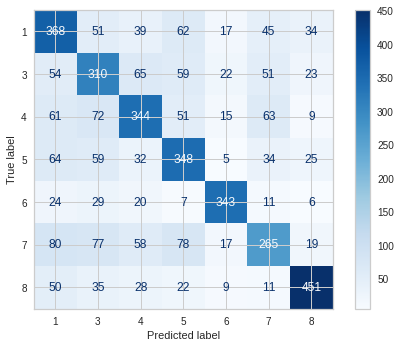


False discovery rate:
 [0.47503566 0.51026856 0.41296928 0.44497608 0.19859813 0.44791667
 0.20458554]

Sensitivity, hit rate, recall, or true positive rate:
 [0.5974026  0.53082192 0.55934959 0.61375661 0.77954545 0.44612795
 0.74422442]

Specificity or true negative rate:
 [0.90223136 0.90605003 0.92896977 0.91924747 0.97627024 0.93728121
 0.96604215]

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.60      0.56       616
           3       0.49      0.53      0.51       584
           4       0.59      0.56      0.57       615
           5       0.56      0.61      0.58       567
           6       0.80      0.78      0.79       440
           7       0.55      0.45      0.49       594
           8       0.80      0.74      0.77       606

    accuracy                           0.60      4022
   macro avg       0.62      0.61      0.61      4022
weighted avg       0.61      0.60      0.60      4022



In [11]:
#SCORE THE TEST SET 
score_test_set(grid, X_test, y_test) 

For the new model we obtained an accuracy of 60,39% and a MCC of 0.5377.

#### ROC curve of the SVM model

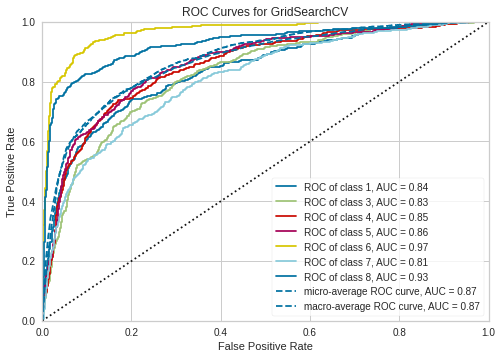

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3420148eb0>,
       encoder={1: '1', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'},
       estimator=GridSearchCV(cv=3, estimator=SVC(),
                              param_grid={'C': [0.01, 0.1, 1],
                                          'kernel': ['linear']},
                              verbose=3))

In [12]:
plot_ROC_curve(grid, X_train, X_test, y_train, y_test)

The class with the most true positive values is the class 6 because it has the higher value of the y axis compared with the others. It has an AUC of 0.97, meaning that there is a 97% change that the model will be able to distinguish the positive class from the negative class. 

#### Feature importance of the SVM model

In this section, we try to understand which feature contribute the most for our SVM model. This can also provide a better biological insight of the dataset.

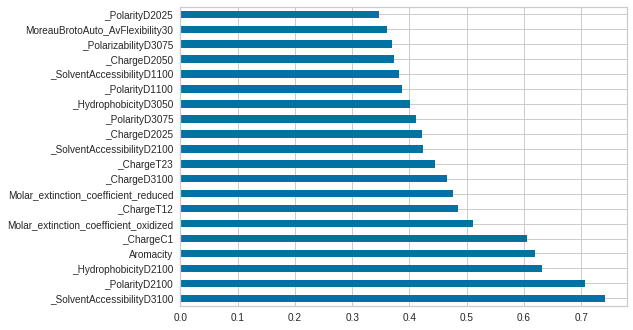

In [13]:
# coef: Weights assigned to the features when kernel="linear"
# Coefficients can be positive or negative (coordinates in hyperplane). Here we are considering the absolute value  

pd.Series(abs(grid.best_estimator_.coef_[0]), index=data_feature_x_new.columns).nlargest(20).plot(kind='barh')


The three most influencial features are: _SolventAcessibilityD3100, _PolarityD2100, _HydrophobicityD2100.

### Grid-Search for Random Forest model

In this step, we made another **Grid-Search** but this time the machine learning model used was the **Random Forest**. 

Also we changed the parametrs in **param_grid** used in the **GridSearchCV**.
The **n_estimators** is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower.

In [14]:
# defining parameter range for RF
# number estimators: The number of trees in the forest.
param_grid = {'n_estimators': [10, 100, 200]}  

#hyperparameter optimization algorithm
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(X_train, y_train)
print(grid.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...................n_estimators=10;, score=0.629 total time=   0.8s
[CV 2/3] END ...................n_estimators=10;, score=0.618 total time=   0.8s
[CV 3/3] END ...................n_estimators=10;, score=0.631 total time=   0.8s
[CV 1/3] END ..................n_estimators=100;, score=0.731 total time=   8.7s
[CV 2/3] END ..................n_estimators=100;, score=0.737 total time=   7.4s
[CV 3/3] END ..................n_estimators=100;, score=0.743 total time=   7.4s
[CV 1/3] END ..................n_estimators=200;, score=0.743 total time=  14.7s
[CV 2/3] END ..................n_estimators=200;, score=0.745 total time=  14.8s
[CV 3/3] END ..................n_estimators=200;, score=0.746 total time=  16.0s
{'n_estimators': 200}


The best parameter obtained with the **GridSearchCV** was 'n_estimators' = 200.

#### Confusion matrix for Grid-Saerch results

We then procided to make another confusion matrix for the new model obtained with the **GridSerchCV** function.

Accuracy: 0.765

MCC: 0.7258

f1 score: [0.69450889 0.70628768 0.78738884 0.79888786 0.85560345 0.66317627
 0.87166667]

Confusion Matrix:



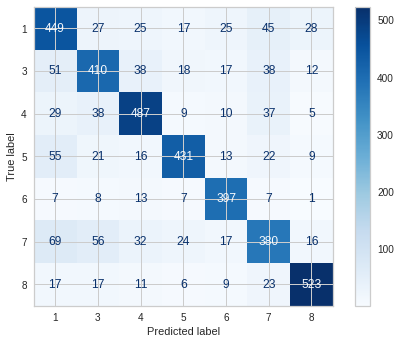


False discovery rate:
 [0.33677991 0.28942808 0.2170418  0.15820312 0.18647541 0.3115942
 0.11952862]

Sensitivity, hit rate, recall, or true positive rate:
 [0.7288961  0.70205479 0.79186992 0.76014109 0.90227273 0.63973064
 0.8630363 ]

Specificity or true negative rate:
 [0.93305931 0.95142525 0.9603757  0.97655572 0.9745952  0.94982497
 0.97921546]

Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.73      0.69       616
           3       0.71      0.70      0.71       584
           4       0.78      0.79      0.79       615
           5       0.84      0.76      0.80       567
           6       0.81      0.90      0.86       440
           7       0.69      0.64      0.66       594
           8       0.88      0.86      0.87       606

    accuracy                           0.77      4022
   macro avg       0.77      0.77      0.77      4022
weighted avg       0.77      0.77      0.76      4022



In [15]:
#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)

For the new model we obtained an accuracy of 76,5% and a MCC of 0.7258.

#### ROC curve of the Random Forest model

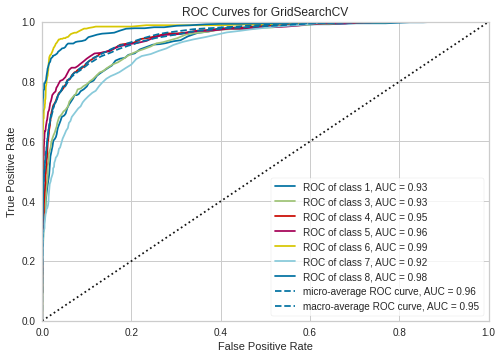

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f341fef91f0>,
       encoder={1: '1', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'},
       estimator=GridSearchCV(cv=3, estimator=RandomForestClassifier(),
                              param_grid={'n_estimators': [10, 100, 200]},
                              verbose=3))

In [16]:
plot_ROC_curve(grid, X_train, X_test, y_train, y_test)

The classes with the most true positive values is the class 6 because it has the higher value of the y axis compared with the others. It has an AUC of 0.99, meaning that there is a 99% change that the model will be able to distinguish the positive class from the negative class. 

#### Feature importance of the Random Forest model

We try to understand which feature contribute the most for our Random Forest model.

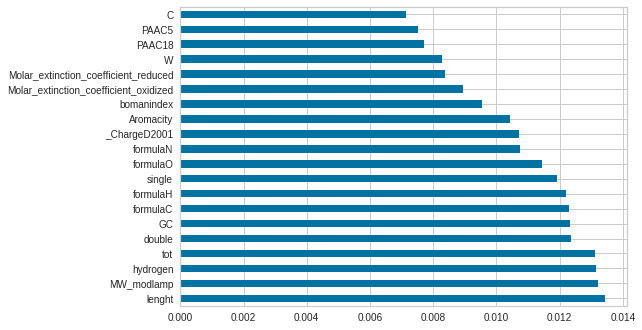

In [17]:
# feature importance for RF
pd.Series(abs(grid.best_estimator_.feature_importances_), index=data_feature_x_new.columns).nlargest(20).plot(kind='barh')

The three most influencial features are: length, MW_modlamp, hydrogen.

## Conclusions

By doing a cross-validation of our four models, Logistic Regression, Random Forest, KNN and SVM, we concluded that the two with the best score are the Random Forest model with 0.758368 and SVM model with a score of 0.718291. After doing the Grid_search to descover the best hyperparameters for each model, we then fitted the model and checked the metrics and the feature importance. 

For the SVM model we obtained an accuracy of 60,39% and a MCC of 0.5377. The three most influencial features obtained were: _SolventAcessibilityD3100, _PolarityD2100 and _HydrophobicityD2100.. For the Random Forest model we obtained an accuracy of 76,5% and a MCC of  0.7258. The three most influencial features obtained were: length, MW_modlamp, hydrogen.

Comparing the two models accuracy's and MCC we can observe that the Random Forest had the better results. 